In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import math

# Bicycle image from points

In [2]:
class BicycleDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.loadtxt(file_path).astype(np.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
dataset = BicycleDataset("bicycle.txt")
dataloader = DataLoader(dataset, batch_size=len(dataset))

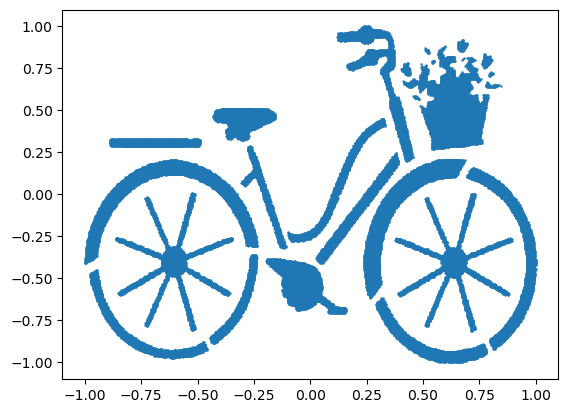

In [4]:
points = next(iter(dataloader))
plt.scatter(points[:, 0], points[:, 1], s=0.5)

# Defining diffusion parameters $\alpha_t$, and $\beta_t$ (variance)

1. Forward process transition from $x_{t-1}$ to $x_{t}$:

$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t \, \mathbf{I})$

2. Forward process from $x_{0}$ to $x_{t}$ (reparametrization):

$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \, x_0, (1 - \bar{\alpha}_t) \, \mathbf{I})$

3. Definitions of $\alpha_t$ and $\bar{\alpha}_t$:

$\alpha_t = 1 - \beta_t \quad \text{and} \quad \bar{\alpha}_t = \prod_{i=1}^t \alpha_i$



In [5]:
T = 1000
beta_start = 0.0001
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas

- manual calculation for $\bar{\alpha}_t$

In [6]:
alphas_t_dash = torch.ones(T)

for t in range(1, T):
    alphas_t_dash[t] = alphas_t_dash[t - 1] * alphas[t]

Text(0.5, 0, 'T')

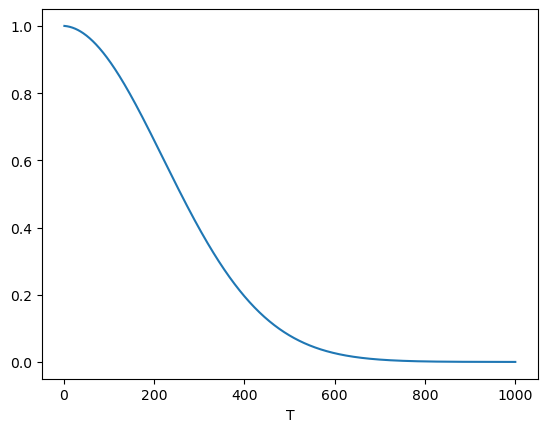

In [7]:
plt.plot(list(range(1, T + 1)), alphas_t_dash)
plt.xlabel("T")

- sigmoid-based sequence calculation for $\bar{\alpha}_t$

In [8]:
sigmoid_sequence = torch.sigmoid(10 * (torch.linspace(0, 1, T) - 0.5))
alphas_t_dash_sigm = sigmoid_sequence.flip(0)  # reversed sigmoid sequence

# scaling to ensure cumulated alphas start from maximum value 0.9999
alphas_t_dash_sigm = alphas_t_dash_sigm / alphas_t_dash_sigm[0]
alphas_t_dash_sigm = torch.clamp(alphas_t_dash_sigm, max=0.9999)

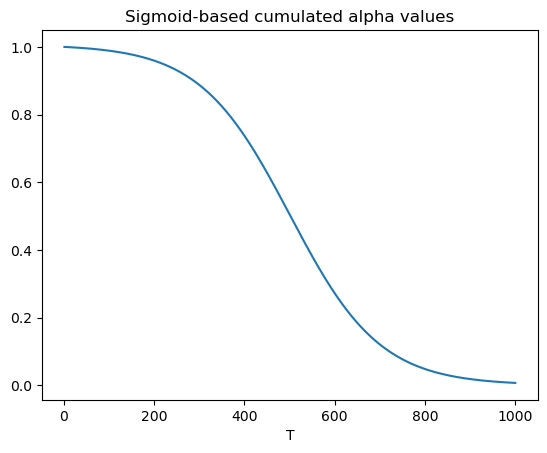

In [9]:
plt.plot(list(range(1, T + 1)), alphas_t_dash_sigm)
plt.xlabel("T")
plt.title("Sigmoid-based cumulated alpha values")
plt.show()

- calculating $\alpha_t$ and $\beta_t$ from sigmoid-based sequence $\bar{\alpha}_t$

In [10]:
alphas_t = torch.zeros(T)
betas_t = torch.zeros(T)

In [11]:
alphas_t[0] = alphas_t_dash_sigm[0]

for t in range(1, T):
    alphas_t[t] = alphas_t_dash_sigm[t] / alphas_t_dash_sigm[t - 1]

alphas_t = torch.clamp(alphas_t, max=0.9999)
betas_t = 1 - alphas_t

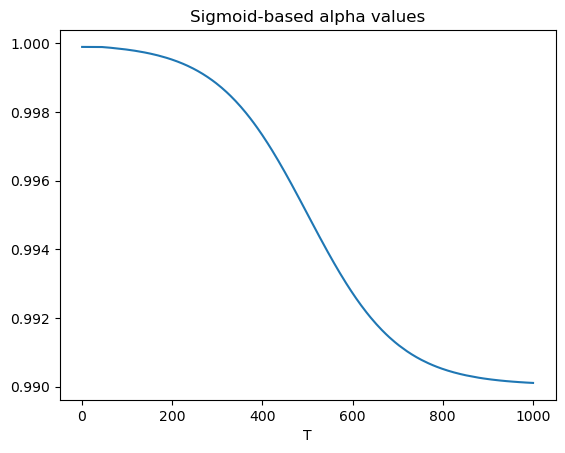

In [12]:
plt.plot(list(range(1, T + 1)), alphas_t)
plt.xlabel("T")
plt.title("Sigmoid-based alpha values")
plt.show()

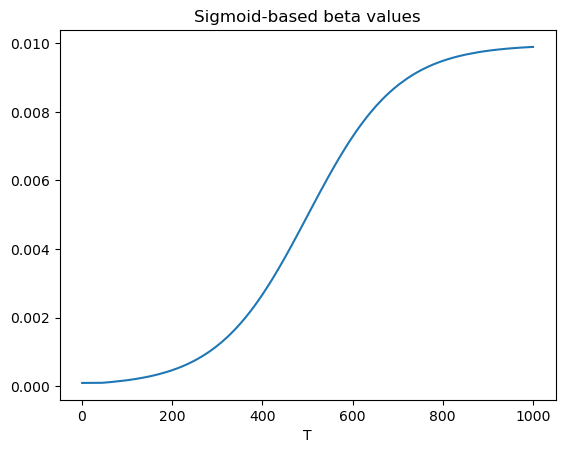

In [13]:
plt.plot(list(range(1, T + 1)), betas_t)
plt.xlabel("T")
plt.title("Sigmoid-based beta values")
plt.show()

# Different diffusion steps $T$ visualization

- forward diffusion

1. Forward diffusion equation:
   
   $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
   
2. Cumulative product of $\alpha_t$:

   $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$

In [14]:
def forward_diffusion(data, t, alphas_t_dash):
    # Gaussian noise for the batch
    noise = torch.randn_like(data)

    sqrt_alpha_t_dash = torch.sqrt(alphas_t_dash[t])
    sqrt_one_minus_alpha_t_dash = torch.sqrt(1 - alphas_t_dash[t])

    # forward diffusion equation
    return sqrt_alpha_t_dash * data + sqrt_one_minus_alpha_t_dash * noise


In [15]:
t_steps = [1, 10, 50, 100, 250, 500, 750, 999]

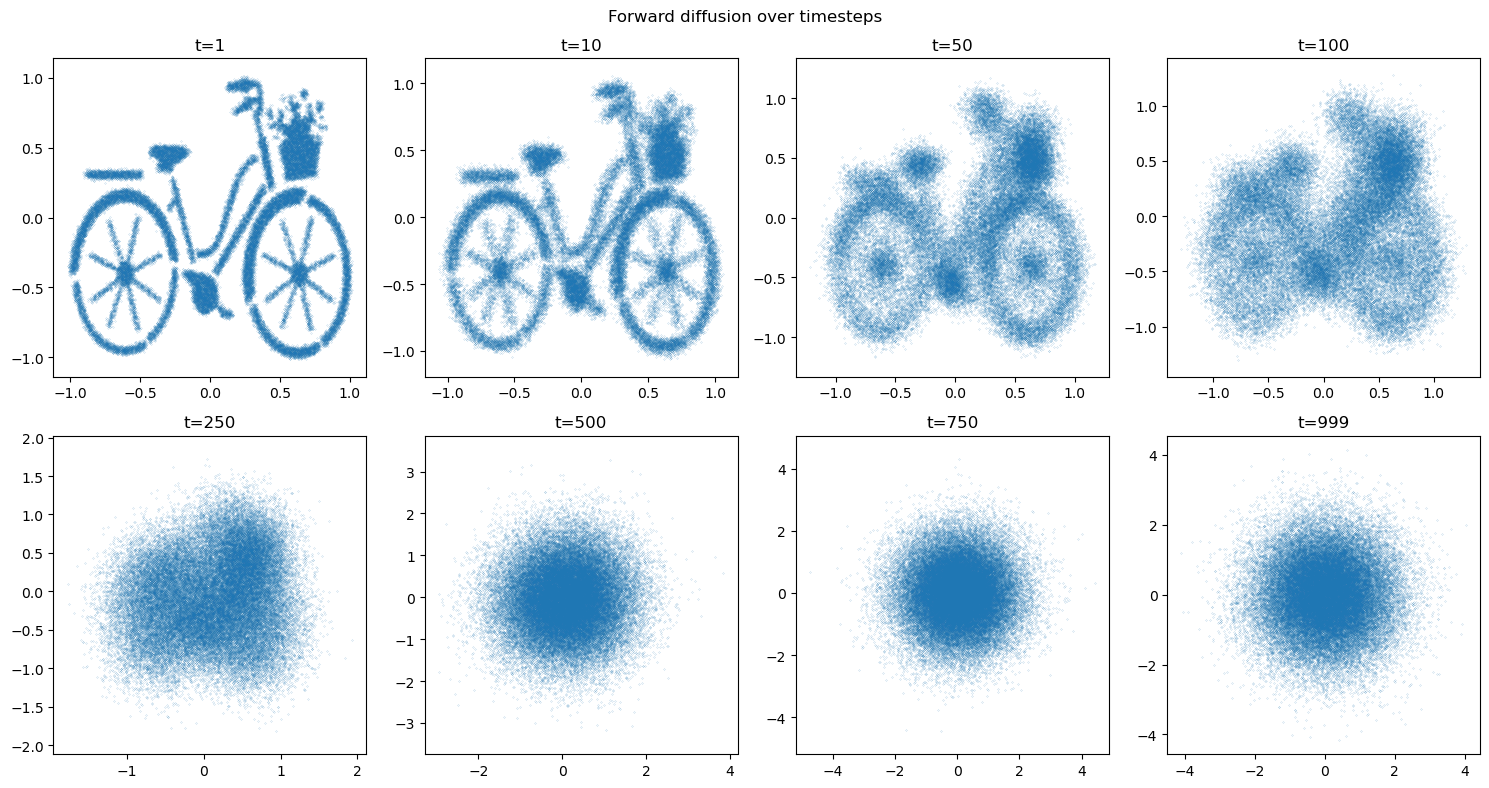

In [16]:
n_cols = 4
n_rows = math.ceil(len(t_steps) / n_cols)

plt.figure(figsize=(15, 8))

for i, t in enumerate(t_steps):
    diffused_data = forward_diffusion(points, t, alphas_t_dash_sigm)
    diffused_data_np = diffused_data.numpy()
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(diffused_data_np[:, 0], diffused_data_np[:, 1], s=0.01)
    plt.title(f"t={t}")
    plt.axis('equal')

plt.suptitle("Forward diffusion over timesteps")
plt.tight_layout()
plt.show()

# Denoising Diffusion Probabilistic Model

- positional encoding

Equations:

- $PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{dim_{enc}}}}\right)$

- $PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{dim_{enc}}}}\right)$


Using the property of logarithms:

$a^x = e^{x \cdot \ln(a)}$

we can rewrite $10000^{\frac{2i}{dim_{enc}}}$ as:

$10000^{\frac{2i}{dim_{enc}}} = e^{\ln(10000) \cdot \frac{2i}{dim_{enc}}}$

So, the denominator becomes (as in the code below):

$\frac{1}{10000^{\frac{2i}{dim_{enc}}}} = e^{-\ln(10000) \cdot \frac{2i}{dim_{enc}}}$

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, enc_dim, t_max):
        super().__init__()
        pos_encoding = torch.zeros(t_max, enc_dim)
        positions = torch.arange(0, t_max, dtype=torch.float).unsqueeze(1)  # shape: [t_max, 1]
        division_term = torch.exp(
            torch.arange(0, enc_dim, 2).float() * (-math.log(10000.0) / enc_dim)
        )  # 10000^(2i/enc_dim)

        # 2i indices
        pos_encoding[:, 0::2] = torch.sin(positions * division_term)
        # 2i+1 indices
        pos_encoding[:, 1::2] = torch.cos(positions * division_term)

        # positional encoding as a buffer (non-trainable tensor)
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, t):
        return self.pos_encoding[t]

- learnable sinusoidal embedding

In [18]:
class LearnableSinusoidalEmbedding(nn.Module):
    def __init__(self, enc_dim, output_dim):
        super().__init__()
        self.positional_enc = PositionalEncoding(enc_dim=enc_dim, t_max=T)
        self.linear1 = nn.Linear(enc_dim, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, output_dim)

    def forward(self, t):
        t_emb = self.positional_enc(t)
        t_emb_transf = self.relu(self.linear1(t_emb))
        # no activation in the last layer
        return self.linear2(t_emb_transf)

- conditional dense layer

In [19]:
class ConditionalDenseLayer(nn.Module):
    def __init__(self, input_dim, output_dim, activation=True):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.embedding = LearnableSinusoidalEmbedding(enc_dim=50, output_dim=output_dim)
        self.relu = nn.ReLU() if activation else nn.Identity()

    def forward(self, x, t):
        x_transformed = self.linear(x)
        t_embedding = self.embedding(t)
        output = x_transformed + t_embedding
        return self.relu(output)

- diffusion model

In [20]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                ConditionalDenseLayer(input_dim=2, output_dim=128),
                ConditionalDenseLayer(input_dim=128, output_dim=128),
                ConditionalDenseLayer(input_dim=128, output_dim=128),
                ConditionalDenseLayer(input_dim=128, output_dim=2, activation=False),
                # no activation in the last layer
            ]
        )

    def forward(self, x, t):
        for layer in self.layers:
            x = layer(x, t)
        return x

- checking encoding and model output size

In [21]:
p = PositionalEncoding(6, 10)
p.pos_encoding

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

In [22]:
print(p(0))
print(p(1))
print(p(4))
print(p(9))

tensor([0., 1., 0., 1., 0., 1.])
tensor([0.8415, 0.5403, 0.0464, 0.9989, 0.0022, 1.0000])
tensor([-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000])
tensor([ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998])


In [23]:
model = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch_size = 64
x = torch.randn(batch_size, 2)
t = torch.randint(0, 1000, (batch_size,)).long()

# forward pass
output = model(x, t)
# shape: [batch_size, 2]
print(f"Output shape: {output.shape}")

Output shape: torch.Size([64, 2])


# Training

![Algorithms](algorithms.png)

In [24]:
def forward_diffusion_array_t(data, t, alphas_t_dash, noise):
    sqrt_alpha_t_dash = torch.sqrt(alphas_t_dash[t.squeeze(-1)])  # shape: (batch_size,)
    sqrt_one_minus_alpha_t_dash = torch.sqrt(1 - alphas_t_dash[t.squeeze(-1)])  # shape: (batch_size,)

    # expanding dimensions for broadcasting with data and noise tensors
    sqrt_alpha_t_dash = sqrt_alpha_t_dash.unsqueeze(1)  # shape: (batch_size, 1)
    sqrt_one_minus_alpha_t_dash = sqrt_one_minus_alpha_t_dash.unsqueeze(1)  # shape: (batch_size, 1)

    # forward diffusion equation
    return sqrt_alpha_t_dash * data + sqrt_one_minus_alpha_t_dash * noise

In [25]:
def generate_points(model, T, n_points, alphas_t, betas_t, alphas_t_dash_sigm):
    x_t = torch.randn(n_points, 2)

    # reversed diffusion
    for t in reversed(range(T)):
        t_tensor = torch.full((n_points,), t, dtype=torch.long)  # Time step tensor
        
        predicted_noise = model(x_t, t_tensor)
        
        alpha_t = alphas_t[t]
        alpha_dash_t = alphas_t_dash_sigm[t]
        beta_t = betas_t[t]
        
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_dash_t)) * predicted_noise
        )
        
        if t > 0:
            z = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t)
            x_t = mean + sigma_t * z
        else:
            x_t = mean  # no noise for the final step

    x_0 = x_t
    return x_0

In [26]:
loss_type = "MSE"

if loss_type == "L1":
    results_dir = "results_loss_l1"
    criterion = nn.L1Loss()
    loss_label = "L1 Loss"
elif loss_type == "MSE":
    results_dir = "results_loss_mse"
    criterion = nn.MSELoss()
    loss_label = "MSE Loss"

In [27]:
os.makedirs(results_dir, exist_ok=True)
log_file = os.path.join(results_dir, "training_logs.txt")

In [28]:
epochs = 2000
batch_size = 64
learning_rate = 0.0001
save_interval = 50

model = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataset = BicycleDataset("bicycle.txt")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

losses = []

In [29]:
for epoch in range(epochs):
    epoch_loss = 0
    for x_0 in dataloader:
        # sampling random time steps t
        t = torch.randint(0, T, (batch_size,), dtype=torch.long)
        noise = torch.randn_like(x_0)

        # forward diffusion of batch
        x_t = forward_diffusion_array_t(x_0, t, alphas_t_dash_sigm, noise)

        # backward - model prediction
        optimizer.zero_grad()
        predicted_noise = model(x_t, t)

        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # average loss for the epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)

    # logging loss
    with open(log_file, "a") as log:
        log.write(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}\n")

    # save model and optimizer state every `save_interval` epochs
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = os.path.join(results_dir, f"training_params_epoch_{epoch+1}.pth")
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch + 1,
        }, checkpoint_path)

        # save loss plot
        plt.figure(figsize=(8, 6))
        plt.plot(losses, label=loss_label, color="orange")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        plot_path = os.path.join(results_dir, f"loss_curves_epoch_{epoch+1}.png")
        plt.savefig(plot_path)
        plt.close()

        # generate and save points
        x_0_generated = generate_points(
            model, T, n_points=10000, alphas_t=alphas_t, betas_t=betas_t, alphas_t_dash_sigm=alphas_t_dash_sigm
        )
        x_0_generated = x_0_generated.detach().numpy()
        plt.figure(figsize=(8, 8))
        plt.scatter(x_0_generated[:, 0], x_0_generated[:, 1], s=0.1)
        plt.title(f"Generated points: epoch {epoch+1}")
        plt.axis("equal")
        points_plot_path = os.path.join(results_dir, f"generated_points_epoch_{epoch+1}.png")
        plt.savefig(points_plot_path)
        plt.close()

# Results

![Loss Curve Epoch 2000](results_loss_mse/loss_curves_epoch_2000.png)

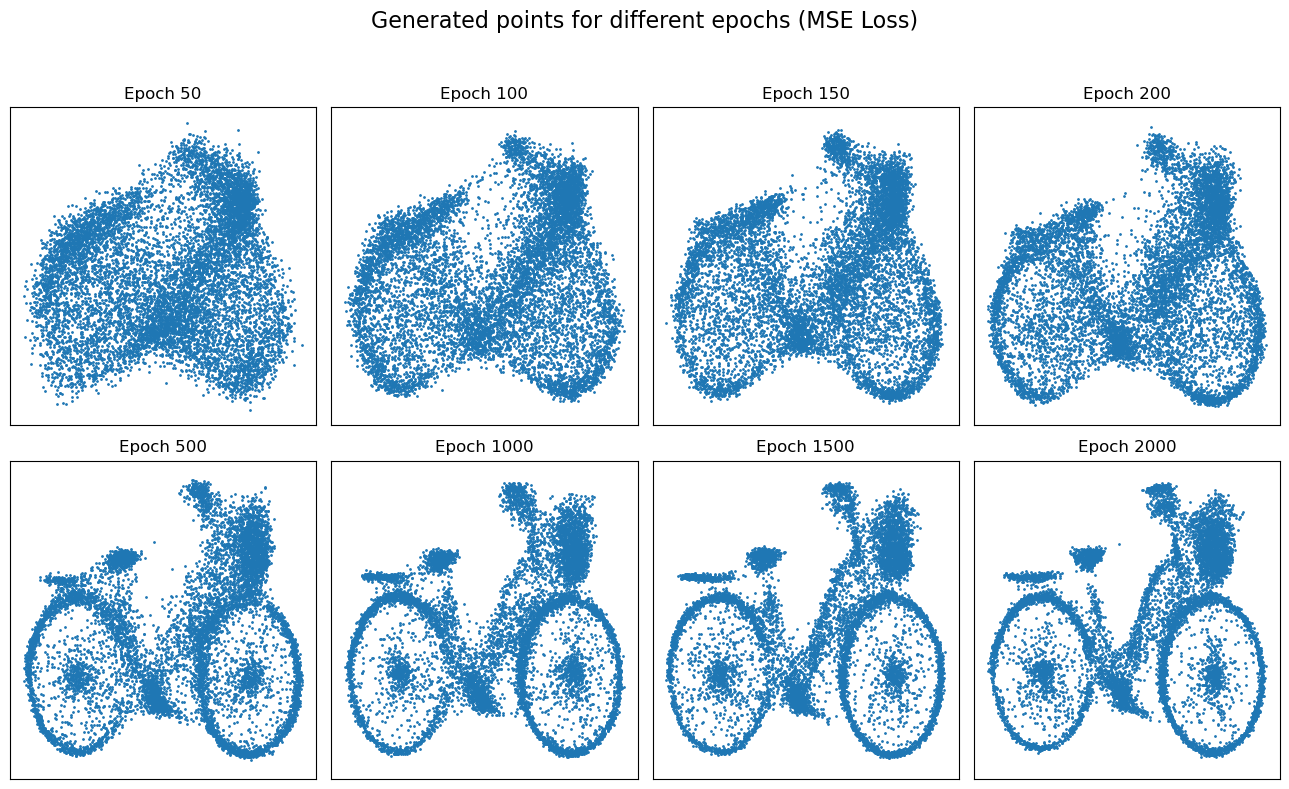

In [30]:
epochs_to_load = [50, 100, 150, 200, 500, 1000, 1500, 2000]

fig, axes = plt.subplots(2, 4, figsize=(13, 8))
fig.suptitle(f"Generated points for different epochs ({loss_label})", fontsize=16)

for i, epoch in enumerate(epochs_to_load):
    checkpoint_path = os.path.join(results_dir, f"training_params_epoch_{epoch}.pth")
    checkpoint = torch.load(checkpoint_path)
    
    model = DiffusionModel()
    model.load_state_dict(checkpoint["model"])
    model.eval()
    
    x_0 = generate_points(
        model, T, n_points=10000, alphas_t=alphas_t, betas_t=betas_t, alphas_t_dash_sigm=alphas_t_dash_sigm
    )
    x_0 = x_0.detach().numpy()
    
    ax = axes[i // 4, i % 4]
    ax.scatter(x_0[:, 0], x_0[:, 1], s=1)
    ax.set_title(f"Epoch {epoch}")
    ax.axis("equal")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()